# Text Mining from the Command Line

John Laudun  
Department of English  
University of Louisiana at Lafayette  
johnlaudun@gmail.com  
http://johnlaudun.org/  
@johnlaudun  



## Agenda

1. Getting data/texts
2. Munging
3. Examining
4. Mining

In [71]:
%matplotlib inline

## Getting Data

### `wget`

Sometimes CLI tools, like `wget`, are more powerful than GUI tools. The key difference is that GUI tools are easier to use at first, but repetitive tasks are difficult or expensive (in terms of time). CLI tools are a little more difficult at first, but once you have an established collection of them, they are not only easier to use but just plain easier. 

**`wget`** is one of those tools. E.g.:

    % wget -r -l 1 -w 2 --limit-rate=20k https://www.cs.cmu.edu/~spok/grimmtmp/

`wget` is a CLI program that retrieves web content. To my mind, since it can act like a targeted web crawler, it is the single greatest tool available to those looking to gather data/texts. 

Let's look at what it looks like:

    % wget -r -l 1 -w 2 --limit-rate=20k https://www.cs.cmu.edu/~spok/grimmtmp/
    
* `-r` (or `--recursive`) turns on recursive retrieving (up to 5 directories deep). 
* `-l 1` (or`--level=1`) keeps the depth to 1.
* `-w 2` gives the amount of time to wait between retrievals. (Two seconds lessens the server load.)
* `--limit-rate=20k` sets the retrieval rate to 20kB/s. (This is being polite in a shared connection setting.)

Our test case comes from Zach Isenhower: http://digital.library.okstate.edu/kappler/Vol2/Toc.htm. 

As it turns out, almost all the documents in which we are interested are housed in a single directory (below), which does not like being crawled. Running `wget` returns **ERROR 403: Forbidden**. In all likelihood, this is the result of the site's administrator configuring the website to make sure that directories cannot be browsed directly.

    !wget -r -l 1 -w 2 --limit-rate=20k http://digital.library.okstate.edu/kappler/Vol2/treaties/

We need, then, to be able to access the table of contents above, get all the links listed, and then download that list into a directory (folder in GUI terms) of our choosing.

## python

In [ ]:
import urllib.request
from bs4 import BeautifulSoup

# To use this script, the user needs to provide the three values below: 
# myurl, myfilter, mydirectory
# Please make sure `mydirectory` is already created before running

myurl = "http://digital.library.okstate.edu/kappler/Vol2/Toc.htm"
myfilter = "http://digital.library.okstate.edu/kappler/Vol2/treaties/"
mydirectory = "/Users/jjl/Desktop/downloadedfiles/"

myconnection = urllib.request.urlopen(myurl)
myhtml = myconnection.read()
mysoup = BeautifulSoup(myhtml, "lxml")
mylinks = mysoup.find_all('a')

all_links = []
for tag in mylinks:
    link = tag.get('href',None)
    if link is not None:
        all_links.append(link)

myresults = [k for k in all_links if myfilter in k]

for result in myresults:
    remotefile = urllib.request.urlopen(result)
    localfile = open(mydirectory+result.replace(myfilter, ''),'wb')
    localfile.write(remotefile.read())
    localfile.close()
    remotefile.close()

To work with this script, all you need to do is provide three variables:

**myurl** is the page that lists the files

**myfilter** is the (remote) directory in which the files are stored

**mydirectory** is the (local) directory to which you wish to save the files. N.B.: You must create this directory ahead of time; and you must provide the absolute path from the root of your OS. The example path is from a Mac; Windows users will need something like `C:\Documents and Setting\username\path\to\folder`.

Now we have a directory (folder) sitting on our desktop and it has all the files we want:

![Screenshot of Full Directory](./Screenshot_directory.png)

## Munging

> **Data munging** or **data wrangling** is loosely the process of manually converting or mapping data from one "raw" form into another format that allows for more convenient consumption of the data with the help of semi-automated tools. This may include further munging, data visualization, data aggregation, training a statistical model, as well as many other potential uses. Data munging as a process typically follows a set of general steps which begin with extracting the data in a raw form from the data source, "munging" the raw data using algorithms (e.g. sorting) or parsing the data into predefined data structures, and finally depositing the resulting content into a data sink for storage and future use.

-- [Wikipedia](https://en.wikipedia.org/wiki/Data_wrangling)

In [ ]:
# Let's take a look at one of Zach's files:

!less apa0598.htm

No matter what Zach has in mind for this data, we can be pretty sure that it does not include a lot of angle brackets and funkiness like `div class="SANSLINE"`. (For the record, *funkiness* is a technical term in data munging. I'm serious. Go look it up.) Whatever Zach's next steps are, he is going to want to clean up the text. 

For this workshop, we are going to skip transforming this html into some kind of operable xml and focus on simply getting it into useful plain text. From there, Zach will be able to engage a number of automated processes which may be more, or less, interesting.

In [ ]:
from bs4 import BeautifulSoup

myfile = open('apa0598.htm', 'r')
myhtml = myfile.read()
mytext = BeautifulSoup(myhtml).text

print(mytext)

Now, we just need to clean up the entire folder!

Again, a bit of automation goes a long way...

In [ ]:
import glob
from bs4 import BeautifulSoup

filesIN = '/Users/jjl/Desktop/downloadedfiles/*.htm'   
filesOUT = "/Users/jjl/Desktop/cleanedfiles/"
    
files=glob.glob(filesIN)

for file in files:     
    f=open(file, 'r')  
    f.readlines()   
    f.close() 
    
for result in myresults:
    remotefile = urllib.request.urlopen(result)
    localfile = open(mydirectory+result.replace(myfilter, ''),'wb')
    localfile.write(remotefile.read())
    localfile.close()
    remotefile.close()

## Text Mining

**Text mining** or **text analytics** (or those same phrases with *data* substituted for *text*) means a lot of things. It can mean simple textual statistics, building a concordance (or seeing key words in context), determining what words co-locate (collocate) with other words within a text or across texts, as well as what words co-occur with others across a number of texts (e.g., topic modeling).

That is, **text mining** is scalable both in terms of *scope*, focusing on small or large patterns, and in terms of *range*, focusing on a single text or dozens, hundreds, thousands of texts.

In our next series of explorations, we are going to use Python's NLTK module to work at the smaller end of the scope:

* work
* through
* NLTK
* book
* examples

### Corpus Views

A lot of our text mining can be done by treating all the texts as one large text file: collocations, concordances, and other textual features can all be explored within a global context. So, one of the common things that needs to get done is to create one text file with which to work.

The way to do this in Python is to read a folder full of texts into a single and then to join those list items into a single text. This seems weird, but this particular way of doing things actually uses less processing power and memory. The good news is that compiling documents into a single list is also the form in which Python's topic modeling module, `gensim`, expects them.

In [ ]:
import glob

file_list = glob.glob('./texts' + '/*.txt')

mytexts = []
for filename in file_list:
    with open(filename, 'r') as f:
        mytexts.append(f.read().replace('\n', ' '))

alltexts = ''.join(mytexts)

With our text now *one big text file*, we can mumble the magic incantations which lets us play with our text within the NLTK:

(If you are ever curious, type `one big text file` into a search engine and saunter through the results.)

**N.B.**: If you ever get the response that you are missing something from NLTK, simply run `nltk.download()` and download what you need using the GUI.

In [10]:
import nltk

tokens = nltk.word_tokenize(alltexts)
text = nltk.Text(tokens)

With that done, we can now begin to explore our corpus:

In [17]:
myword = text.concordance("recommend")
print(myword)

Displaying 25 of 54 matches:
ng in any of the party which could recommend them as companions to the Dashwood
should it ever be in your power to recommend him to any body that has a living 
 `` They have none of them much to recommend them , '' replied he ; `` they are
`` She has nothing , in short , to recommend her , but being an excellent walke
 of those young ladies who seek to recommend themselves to the other sex by und
late Mr. Darcy 's steward . Let me recommend you , however , as a friend , not 
 offend Mr. Darcy ? You will never recommend yourself to his friend by so doing
ject was by delicate attentions to recommend himself to her and that he should 
ho has neither manner nor sense to recommend him . Stupid men are the only ones
imes to their different doors , to recommend their being quick , as Lady Cather
uction ; but I am ill-qualified to recommend myself to strangers . '' `` Shall 
in the world , is ill qualified to recommend himself to strangers ? '' `` I can
ounding , b

In [27]:
text.similar("recommend")

make do have give see be hear believe her think bring find know read
put get ask like feel take


In [20]:
text.common_contexts(["husband", "wife"])

the_he a_and the_of the_had good_and the_to


In [23]:
text.collocations()

Sir Thomas; Captain Wentworth; Mrs. Jennings; Mr. Knightley; great
deal; Miss Crawford; Mr. Darcy; dare say; Mrs. Weston; Frank
Churchill; young man; Lady Russell; Colonel Brandon; Mr. Elton; Mrs.
Norris; Sir Walter; every thing; Miss Woodhouse; Lady Bertram; Mr.
Crawford


In [28]:
text.generate()

AttributeError: 'Text' object has no attribute 'generate'

### Single Text Views

We can also work with single texts to understand them in new ways. Here we will work with a short story, "The Most Dangerous Game," published in time for it to be both in the public domain and yet remain a part of our collective literary/semiotic tradition.

In [38]:
# First, let's load the text file:
mdg = open("./mdg.txt").read()

In [39]:
# Next, let's find out how long it is:
len(mdg)

44078

In [43]:
# 44078 what? Characters. We prefer words:

mdgtokens = nltk.word_tokenize(mdg)
len(mdgtokens)

9717

In [48]:
# 9717 words AND punctuation marks. 

import re

mdg_words = re.sub("[^a-zA-Z'-]"," ", open("./mdg.txt").read())
print(mdg_words)

 OFF THERE to the right somewhere is a large island   said Whitney   It s rather a mystery    What island is it   Rainsford asked   The old charts call it 'Ship-Trap Island '  Whitney replied   A suggestive name  isn t it  Sailors have a curious dread of the place  I don t know why  Some superstition    Can t see it   remarked Rainsford  trying to peer through the dank tropical night that was palpable as it pressed its thick warm blackness in upon the yacht   You ve good eyes   said Whitney  with a laugh   and I ve seen you pick off a moose moving in the brown fall bush at four hundred yards  but even you can t see four miles or so through a moonless Caribbean night    Nor four yards   admitted Rainsford   Ugh  It s like moist black velvet    It will be light enough in Rio   promised Whitney   We should make it in a few days  I hope the jaguar guns have come from Purdey s  We should have some good hunting up the Amazon  Great sport  hunting    The best sport in the world   agreed Rains

In [49]:
len(mdg_words)

44078

In [51]:
mdg_word_list = mdg_words.split()
print(mdg_word_list)

['OFF', 'THERE', 'to', 'the', 'right', 'somewhere', 'is', 'a', 'large', 'island', 'said', 'Whitney', 'It', 's', 'rather', 'a', 'mystery', 'What', 'island', 'is', 'it', 'Rainsford', 'asked', 'The', 'old', 'charts', 'call', 'it', "'Ship-Trap", 'Island', "'", 'Whitney', 'replied', 'A', 'suggestive', 'name', 'isn', 't', 'it', 'Sailors', 'have', 'a', 'curious', 'dread', 'of', 'the', 'place', 'I', 'don', 't', 'know', 'why', 'Some', 'superstition', 'Can', 't', 'see', 'it', 'remarked', 'Rainsford', 'trying', 'to', 'peer', 'through', 'the', 'dank', 'tropical', 'night', 'that', 'was', 'palpable', 'as', 'it', 'pressed', 'its', 'thick', 'warm', 'blackness', 'in', 'upon', 'the', 'yacht', 'You', 've', 'good', 'eyes', 'said', 'Whitney', 'with', 'a', 'laugh', 'and', 'I', 've', 'seen', 'you', 'pick', 'off', 'a', 'moose', 'moving', 'in', 'the', 'brown', 'fall', 'bush', 'at', 'four', 'hundred', 'yards', 'but', 'even', 'you', 'can', 't', 'see', 'four', 'miles', 'or', 'so', 'through', 'a', 'moonless', 'Car

In [52]:
len(mdg_word_list)

8109

In [54]:
sorted(mdg_word_list)

["'",
 "'Ship-Trap",
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'About',
 'Across',
 'Africa',
 'Africa',
 'After',
 'Again',
 'Again',
 'Again',
 'Ah',
 'Ah',
 'All',
 'All',
 'Always',
 'Amazon',
 'Amazon',
 'America',
 'America',
 'American',
 'American',
 'Americans',
 'An',
 'An',
 'An',
 'An',
 'An',
 'And',
 'And',
 'And',
 'And',
 'And',
 'And',
 'And',
 'And',
 'And',
 'Another',
 'Anyhow',
 'As',
 'As',
 'As',
 'At',
 'At',
 'At',
 'Au',
 'Aurelius',
 'Automatically',
 'Bah',
 'Be',
 'Bergere',
 'Better',
 'Bleak',
 'Boredom',
 'Burmese',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'But',
 'Butterfly',
 'By',
 'Can',
 'Cannibals',
 'Cape',
 'Cape',
 'Cape',
 'Cape',
 'Captain',
 'Caribbean',
 'Caribbean',
 'Carlo',
 'Caucasus',
 'Chablis',
 'Chablis',
 'Chambertin',
 'Chinese',
 'City',
 'Civilized',
 'Cliquot',
 'C

In [56]:
sorted(set(mdg_word_list))

["'",
 "'Ship-Trap",
 'A',
 'About',
 'Across',
 'Africa',
 'After',
 'Again',
 'Ah',
 'All',
 'Always',
 'Amazon',
 'America',
 'American',
 'Americans',
 'An',
 'And',
 'Another',
 'Anyhow',
 'As',
 'At',
 'Au',
 'Aurelius',
 'Automatically',
 'Bah',
 'Be',
 'Bergere',
 'Better',
 'Bleak',
 'Boredom',
 'Burmese',
 'But',
 'Butterfly',
 'By',
 'Can',
 'Cannibals',
 'Cape',
 'Captain',
 'Caribbean',
 'Carlo',
 'Caucasus',
 'Chablis',
 'Chambertin',
 'Chinese',
 'City',
 'Civilized',
 'Cliquot',
 'Come',
 'Cossack',
 'Crimea',
 'Czar',
 'Dear',
 'Death',
 'Dense',
 'Desperately',
 'Did',
 'Didn',
 'Do',
 'Don',
 'Doubtless',
 'Down',
 'Dusk',
 'Eagerly',
 'East',
 'English',
 'Ennui',
 'Even',
 'Ever',
 'Every',
 'Folies',
 'Follow',
 'Following',
 'For',
 'Fractured',
 'France',
 'French',
 'From',
 'Ganges',
 'Gasping',
 'General',
 'Get',
 'God',
 'God-forsaken',
 'Good',
 'Great',
 'Guns',
 'Half',
 'Hardly',
 'He',
 'Here',
 'His',
 'How',
 'Hunting',
 'Hurled',
 'I',
 'If',
 'Ill'

In [57]:
len(sorted(set(mdg_word_list)))

2063

In [60]:
import re

mdg2 = open("./mdg.txt").read()
mdg2_words = re.sub("[^a-zA-Z'-]"," ", open("./mdg.txt").read().lower())
mdg2_word_list = mdg2_words.split()
len(sorted(set(mdg2_word_list)))

1929

In [66]:
# Lexical Diversity of MDG:
len(mdg2_word_list) / len(set(mdg2_word_list))

4.203732503888025

We can also use the NLTK to explore a single text.

In [ ]:
import nltk, re

mdg_raw = open("./mdg.txt").read()
mdg_words = re.sub("[^a-zA-Z'-]"," ", mdg_raw)
mdg_case = mdg_words.lower()

print(mdg_case)

In [80]:
mdg_tokens = nltk.word_tokenize(mdg_case)
mdg_text = nltk.Text(mdg_tokens)

In [81]:
len(mdg_tokens)

8109

In [82]:
len(mdg_tokens) / len(set(mdg_tokens))

4.203732503888025

On average, a word occurs four times in "The Most Dangerous Game."

Out of curiosity, how many words occur four times?

In [114]:
wordfrequency = nltk.FreqDist(mdg_tokens)
four_times = [word for word in wordfrequency.keys() if wordfrequency[word] == 4]
print(four_times)

['strength', 'perhaps', 'nothing', 'sailors', 'leaped', 'let', 'old', 'voice', 'near', 'small', 'kind', 'direction', 'pointing', 'struck', 'jaguar', 'cut', 'bottle', 'may', 'mind', 'real', 'tigers', 'long', 'lost', 'going', 'steps', 'branches', 'left', 'glass', 'read', 'dangerous', 'hundred', 'danger', 'head', 'fall', 'shoulders', 'suppose', 'raised', 'water', 'flight', 'day', 'sometimes', 'seemed', 'faint', 'young', 'answer', 'lips', 'idea', 'hunted', 'mean', 're', 'tried', 'turned', 'shook', 'evil', 'asked', 'climbed', 'chateau', 'buffalo', 'still', 'opened', 'evening', 'want', 'cape', 'death', 'shore', 'mine', 'bush', 'huge']


In [84]:
mdg_text.count("dangerous")

4

In [83]:
mdg_text.concordance("dangerous")

Displaying 4 of 4 matches:
 that the cape buffalo is the most dangerous of all big game for a moment the g
r the cape buffalo is not the most dangerous big game he sipped his wine here i
 in the same slow tone i hunt more dangerous game rainsford expressed his surpr
reason after a fashion so they are dangerous but where do you get them the gene


Where does "dangerous" occur within the larger text?

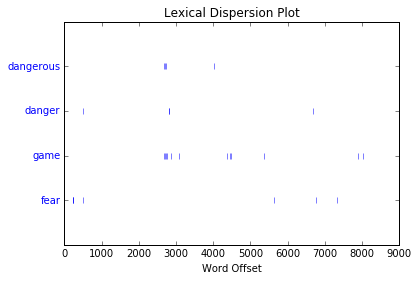

In [115]:
mdg_text.dispersion_plot(["dangerous", "danger", "game", "fear"])

## Topic Modeling

 a very basic GUI for MALLET: https://code.google.com/archive/p/topic-modeling-tool/

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


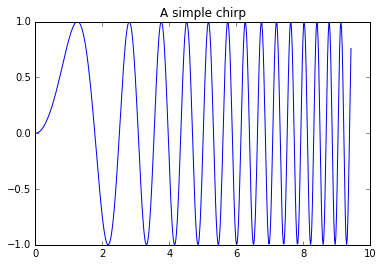

In [2]:
x = linspace(0, 3*pi, 500)
plot(x, sin(x**2))
title('A simple chirp');

## Creating a Slideshow

Creating a slideshow is as easy as:

    ipython nbconvert your_slides.ipynb --to slides

If you want to immediately serve the slides to your web browser, just add `--post serve` at the command-line:

    ipython nbconvert your_slides.ipynb --to slides --post serve